# Exploratory anaylsis

## SECTION 1: Setup & Data Loading

- 1.1 Install required packages

- 1.2 Import libraries

- 1.3  Load datasets

### __1.1 Install required packages__

In [1]:
#__1.1 Install required packages__
!pip install osmnx # this for the network analysis

### __1.2 Import libraries__

In [2]:
#__1.2 Import libraries__

# Core data manipulation and analysis
import pandas as pd                       # For data manipulation and analysis
import numpy as np                        # For numerical computations

# Geospatial data handling
import geopandas as gpd                   # For handling geographic data and shapefiles
from geopandas.tools import sjoin         # For joining the grids to the boundary data
import rasterio                           # For reading and processing raster data (population, malaria)
from rasterio.features import rasterize
from rasterio.features import shapes
from rasterio.warp import calculate_default_transform, reproject, Resampling # For reprojecting rasters to target CRS
from rasterio.enums import Resampling     # For scaling the raster data pop and malaria data
import rasterio.mask                      # For define analysis region and clip rasters


# Visualization
import matplotlib.pyplot as plt           # For creating maps and visualisations
import seaborn as sns                     # For statistical visualisations
import colorcet as cc                     # for plotting the network with weights
from rasterio.plot import plotting_extent # plotting raster data
from matplotlib.colors import LogNorm     # For applying a logarithmic scale to color intensity in plots


# Spatial operations
from shapely.geometry import shape
from shapely.geometry import Polygon
from scipy.spatial.distance import cdist  # For spatial indexing and nearest neighbour searches
from scipy.spatial import cKDTree
from shapely.geometry import Point
from sklearn.cluster import KMeans        # For candidate location generation

# Network anaylsis
import networkx as nx                     # For road network analysis and shortest path calculations
import osmnx as ox                        # For downloading and processing OpenStreetMap road data

# others
import os

print("library Loading and Initial Setup")
print("-"*50)


library Loading and Initial Setup
--------------------------------------------------


### __1.4 Load datasets:__

The datasets are hospital location data
- Ghana Health Facility Locations 
- Population Distribution
- Malaria Incidence
- Ghana Administrative Boundaries 
- Road Networks  


#### __1.4.1 Ghana Health Facility Locations__

**Data Source:** Ghana Health Service facility registry, scraped from ArcGIS Ghana hospital locations database. This represents the most comprehensive public and up-to-date inventory of health facilities in Ghana.

In [3]:
# Load hospital locations from CSV file
hospitals = pd.read_csv('DATA/hospital_data_new/ghana_health_facilities_cleaned.csv')
print(f"✓ Loaded {len(hospitals)} hospitals from local CSV")

# Quick preview of the data structure
hospitals.head(5)    # View first 5 rows
hospitals.columns    # See column names
hospitals.info       # Check data types and non-null counts


✓ Loaded 2843 hospitals from local CSV


<bound method DataFrame.info of       OBJECTID   Region                 District                   FacilityNa  \
0            1  Ashanti            Offinso North            A.M.E Zion Clinic   
1            2  Ashanti         Bekwai Municipal            Abenkyiman Clinic   
2            3  Ashanti             Adansi North         Aboabo Health Centre   
3            4  Ashanti            Afigya-Kwabre      Aboabogya Health Centre   
4            5  Ashanti                   Kwabre         Aboaso Health Centre   
...        ...      ...                      ...                          ...   
2838      2839  Western        Wassa-Amenfi West            St.Theresa Clinic   
2839      2840  Western        Wassa-Amenfi West            Samartex Hospital   
2840      2841  Western        Shama Ahanta East             Infirmary Clinic   
2841      2842  Western        Shama Ahanta East  Scho ol for the Deaf Clinic   
2842      2843  Western  Bibiani-Anhwiaso-Bekwai                Dominebo CHPS

### __1.4.2 Population Distribution__

**Data Source:** WorldPop Project - globally consistent population distribution estimates using satellite imagery and census data disaggregation.

In [4]:
# Open population raster file (WorldPop data)
population_raster = rasterio.open('DATA/ghana_population_constrained/gha_ppp_2020.tif')

# Check raster properties
print(f"Population raster shape: {population_raster.shape}")
print(f"Coordinate system: {population_raster.crs}")
print(f"Pixel resolution: {population_raster.res}")

Population raster shape: (7721, 5337)
Coordinate system: EPSG:4326
Pixel resolution: (0.000833333329960652, 0.0008333333300090661)


The raster data has 7721 rows (vertical pixels) and 5337 columns (horizontalpixels). Hence, the total number of cells (pixels) is:

                               7721 × 5337 = 41,221,377 pixels

WorldPop has 100m resolution for Ghana population estimates - each pixel represents the number of people in a 100m x 100m area. The geographic coordinates (latitude and longitude) is in EPSG:4326, WGS84 a standard GPS coordinate system. Next we want to actual population in the data. We expect population values to be non-negative numbers. The total should roughly match Ghana’s known population.

In [5]:
# Read the actual population values
population_data = population_raster.read(1)  # Read first (and only) band

# Replace negative values with NaN
population_data_clean = np.where(population_data < 0, np.nan, population_data) # replaces all negative values in the raster (e.g., -99999, -999999, or -1) with np.nan.

# Verify cleaned data
# printing the smallest and largest real (non-NaN) values in the cleaned population data.
print(f"Population range: {np.nanmin(population_data_clean)} to {np.nanmax(population_data_clean)}")

# Calculate total estimated population
total_population = np.nansum(population_data_clean)            # sums all values in the raster but ignores np.nan cells
print(f"Total estimated population: {total_population:,.0f}")  # true estimated population across all valid pixels

Population range: 0.03166040778160095 to 240.66934204101562
Total estimated population: 33,039,582


The total estimated population is 33,039,582, which aligns closely with Ghana's actual estimated population (around 32–34 million as per recent statistics). next I will plot it.

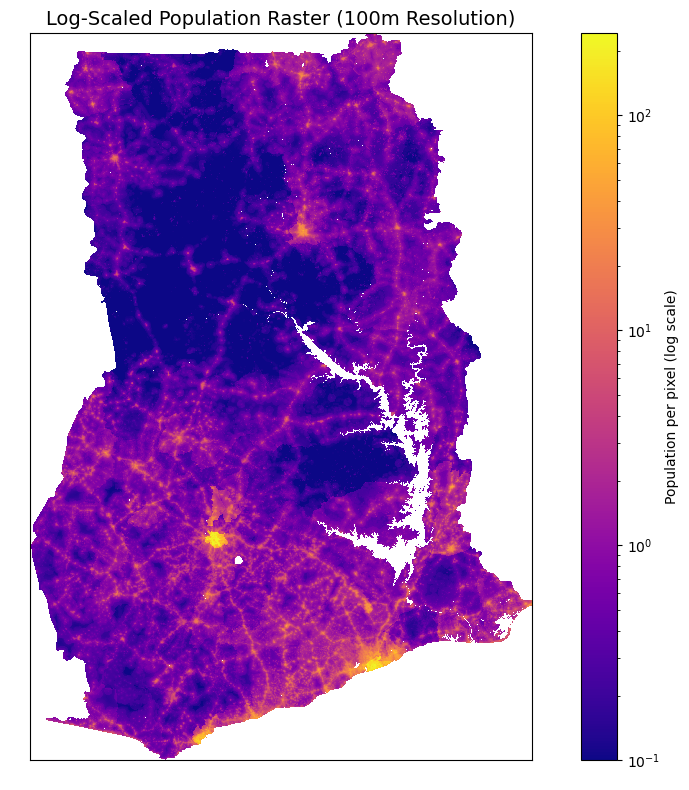

In [6]:
# Get the extent using population_raster
extent = plotting_extent(population_raster)

# Plot the population raster
plt.figure(figsize=(10, 8))
pop_plot = plt.imshow(population_data_clean,       # The raster data to display
                      cmap='plasma',               # Colour map for visual intensity
                      extent=extent,               # Spatial extent for correct georeferencing
                      interpolation='none',        # No smoothing between pixels (preserve sharp boundaries)
                      norm=LogNorm(                # Apply logarithmic color scaling
                          vmin=0.1,                # Minimum visible value (avoids log(0))
                          vmax=np.nanmax(population_data_clean)))  # Maximum value (ignoring NaNs)

plt.colorbar(pop_plot, label='Population per pixel (log scale)') # Add a colorbar to show what the colors represent in terms of population values
plt.title('Log-Scaled Population Raster (100m Resolution)', fontsize=14) # Set the main title for the plot
plt.xticks([ ])    # Remove all tick values on the x-axis
plt.yticks([ ])    # Remove all tick values on the y-axis
plt.xlabel(' ')   # Remove x-axis label ("Longitude")
plt.ylabel(' ')   # Remove y-axis label ("Latitude")
plt.tight_layout()
plt.show()  # Show the final plot

### __1.4.3 Malaria Incidence__
**Data Source:** Malaria Atlas Project (MAP) - the good standard for malaria epidemiological data, providing globally consistent malaria incidence estimates.

In [7]:
# Open malaria incidence raster (MAP data)
malaria_raster = rasterio.open('DATA/ghana_malaria_incidence/2020_Global_Pf_Incidence_GHA_2019.tiff')

# Read malaria incidence rates (cases per 1000 population)
malaria_data = malaria_raster.read(1)

print(f"Malaria raster shape: {malaria_data.shape}")
print(f"Incidence range: {malaria_data.min():.1f} to {malaria_data.max():.1f} per 1000")

Malaria raster shape: (155, 107)
Incidence range: -9999.0 to 0.4 per 1000


In [8]:
# Replace no-data (-9999) with np.nan
malaria_data_cleaned = np.where(malaria_data < 0, np.nan, malaria_data)

# Print range after cleaning
print(f"Cleaned malaria range: {np.nanmin(malaria_data_cleaned):.2f} to {np.nanmax(malaria_data_cleaned):.2f} per 1000")

Cleaned malaria range: 0.00 to 0.44 per 1000


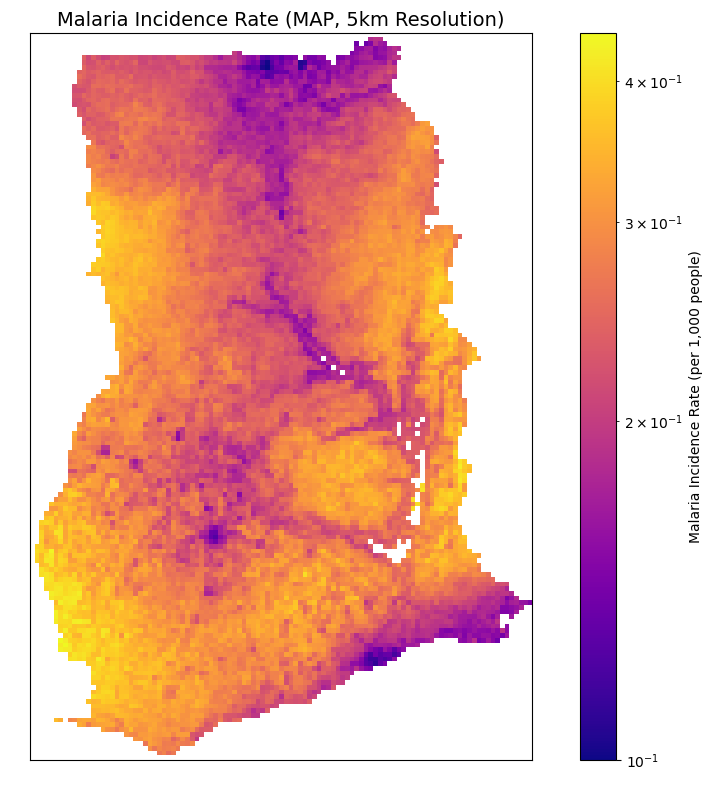

In [9]:
# Get the extent using malaria_data_r
extent = plotting_extent(malaria_raster)

# Plot the malaria raster
plt.figure(figsize=(10, 8))
pop_plot = plt.imshow(malaria_data_cleaned,       # The raster data to display
                      cmap='plasma',               # Colour map for visual intensity
                      extent=extent,               # Spatial extent for correct georeferencing
                      interpolation='none',        # No smoothing between pixels (preserve sharp boundaries)
                      norm=LogNorm(                # Apply logarithmic color scaling
                          vmin=0.1,                # Minimum visible value (avoids log(0))
                          vmax=np.nanmax(malaria_data_cleaned)))  # Maximum value (ignoring NaNs)

plt.colorbar(pop_plot, label='Malaria Incidence Rate (per 1,000 people)') # Add a colorbar to show what the colors represent in terms of population values
plt.title('Malaria Incidence Rate (MAP, 5km Resolution)', fontsize=14) # Set the main title for the plot
plt.xticks([ ])    # Remove all tick values on the x-axis
plt.yticks([ ])    # Remove all tick values on the y-axis
plt.xlabel(' ')   # Remove x-axis label ("Longitude")
plt.ylabel(' ')   # Remove y-axis label ("Latitude")
plt.tight_layout()
plt.show()  # Show the final plot

### __1.4.4 Ghana Administrative Boundaries __

**Data Source:** GADM

In [10]:
# Load Ghana administrative boundaries
boundaries = gpd.read_file('DATA/boundaries_data/gadm41_GHA_1.shp') # Regional boundaries

# Check what administrative levels we have
print(f"Administrative areas loaded: {len(boundaries)}")  # number of regions 
print(f"Available columns: {list(boundaries.columns)}")   # column heads

boundaries.head()

Administrative areas loaded: 16
Available columns: ['GID_1', 'GID_0', 'COUNTRY', 'NAME_1', 'VARNAME_1', 'NL_NAME_1', 'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'geometry']


,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,GHA1_2,GHA,Ghana,Ahafo,NA,NA,Region,Region,NA,NA,GH-AF,"POLYGON ((-2.41599 6.6588, -2.41612 6.65887, -..."
1,GHA2_2,GHA,Ghana,Ashanti,NA,NA,Region,Region,NA,NA,GH-AH,"POLYGON ((-0.75537 6.91273, -0.75536 6.9127, -..."
2,GHA3_2,GHA,Ghana,Bono,NA,NA,Region,Region,NA,NA,GH-BO,"POLYGON ((-2.86623 6.8524, -2.86639 6.85248, -..."
3,GHA4_2,GHA,Ghana,Bono East,NA,NA,Region,Region,NA,NA,GH-BE,"POLYGON ((-1.43358 7.57346, -1.4352 7.56992, -..."
4,GHA5_2,GHA,Ghana,Central,NA,NA,Region,Region,NA,NA,GH-CP,"POLYGON ((-0.75619 5.71017, -0.75569 5.71023, ..."


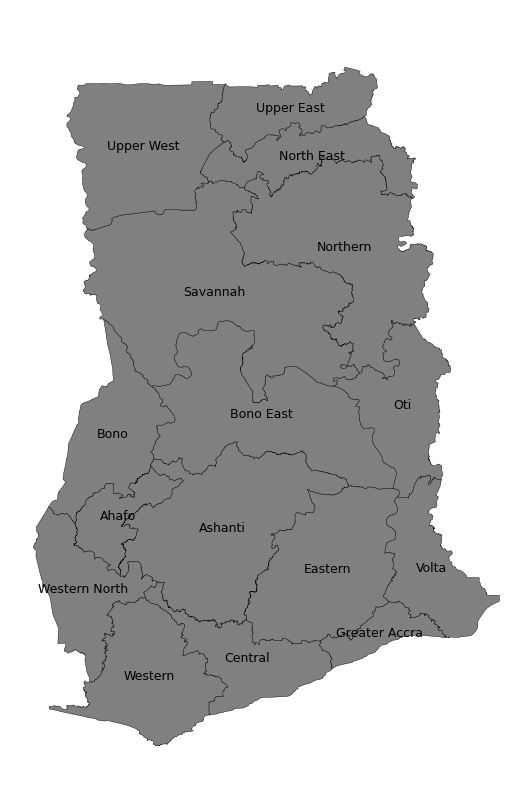

In [11]:
# visualizing Ghana's regional administrative

# Set up plot with black background
fig, ax = plt.subplots(figsize=(10, 8), facecolor='gray')
fig.patch.set_facecolor('white')    # Set outer figure background to black
ax.set_facecolor('gray')           # Set inner plotting area background to black
 
# Plot boundaries with black edges and Light Mocha fill
boundaries.plot(ax=ax, edgecolor='black', facecolor='gray', linewidth=0.3) # using the whole country (boundaries) as the subject

# Add region names (label centroids)
for idx, row in boundaries.iterrows():
    centroid = row.geometry.centroid    # Get center of each region
    ax.text(centroid.x, centroid.y, row['NAME_1'], 
            color='black', fontsize=9, ha='center', va='center')   # Add label at centroid

# Style and display
ax.set_title('Ghana Administrative Regions', color='white', fontsize=14)   # Add map title
ax.axis('off')      # Hide axes ticks and frame
plt.tight_layout()  # Prevent label or title cut-offs
plt.show()          # Display the map



## section 1.5 cleaning raster dataset

In [12]:
# Step 1: Examine Your Raster Data Quality
# Let's look at what problems exist in your raster data

import numpy as np
import matplotlib.pyplot as plt

print("🔍 EXAMINING RASTER DATA QUALITY")
print("=" * 50)

# ================================================================
# POPULATION RASTER EXAMINATION
# ================================================================
print("\n📊 POPULATION RASTER:")
print("-" * 30)

print(f"Shape: {population_data_clean.shape}")
print(f"Data type: {population_data_clean.dtype}")

# Check for problematic values
print("\n🔍 Checking for problems in population data:")

# Count different types of problematic values
total_pixels = population_data_clean.size
nan_count = np.isnan(population_data_clean).sum()
inf_count = np.isinf(population_data_clean).sum()
negative_count = np.sum(population_data_clean < 0)
zero_count = np.sum(population_data_clean == 0)
positive_count = np.sum(population_data_clean > 0)

print(f"  Total pixels: {total_pixels:,}")
print(f"  NaN (missing) values: {nan_count:,} ({nan_count/total_pixels*100:.1f}%)")
print(f"  Infinite values: {inf_count:,}")
print(f"  Negative values: {negative_count:,} ({negative_count/total_pixels*100:.1f}%)")
print(f"  Zero values: {zero_count:,} ({zero_count/total_pixels*100:.1f}%)")
print(f"  Positive values: {positive_count:,} ({positive_count/total_pixels*100:.1f}%)")

# Statistics for valid (non-NaN, positive) values only
valid_pop = population_data_clean[~np.isnan(population_data_clean) & (population_data_clean > 0)]
if len(valid_pop) > 0:
    print(f"\n📈 Statistics for valid population values:")
    print(f"  Minimum: {np.min(valid_pop):.2f}")
    print(f"  Maximum: {np.max(valid_pop):,.0f}")
    print(f"  Average: {np.mean(valid_pop):.2f}")
    print(f"  Total: {np.sum(valid_pop):,.0f}")
else:
    print(f"\n⚠️  No valid population values found!")

# ================================================================
# MALARIA RASTER EXAMINATION  
# ================================================================
print("\n\n🦟 MALARIA RASTER:")
print("-" * 30)

print(f"Shape: {malaria_data_cleaned.shape}")
print(f"Data type: {malaria_data_cleaned.dtype}")

# Check for problematic values in malaria data
print("\n🔍 Checking for problems in malaria data:")

total_malaria_pixels = malaria_data_cleaned.size
nan_malaria = np.isnan(malaria_data_cleaned).sum()
inf_malaria = np.isinf(malaria_data_cleaned).sum()
negative_malaria = np.sum(malaria_data_cleaned < 0)
zero_malaria = np.sum(malaria_data_cleaned == 0)
positive_malaria = np.sum(malaria_data_cleaned > 0)

print(f"  Total pixels: {total_malaria_pixels:,}")
print(f"  NaN (missing) values: {nan_malaria:,} ({nan_malaria/total_malaria_pixels*100:.1f}%)")
print(f"  Infinite values: {inf_malaria:,}")
print(f"  Negative values: {negative_malaria:,} ({negative_malaria/total_malaria_pixels*100:.1f}%)")
print(f"  Zero values: {zero_malaria:,} ({zero_malaria/total_malaria_pixels*100:.1f}%)")
print(f"  Positive values: {positive_malaria:,} ({positive_malaria/total_malaria_pixels*100:.1f}%)")

# Statistics for valid malaria values
valid_malaria = malaria_data_cleaned[~np.isnan(malaria_data_cleaned) & (malaria_data_cleaned >= 0)]
if len(valid_malaria) > 0:
    print(f"\n📈 Statistics for valid malaria incidence rates:")
    print(f"  Minimum: {np.min(valid_malaria):.3f} per 1,000/year")
    print(f"  Maximum: {np.max(valid_malaria):.3f} per 1,000/year")
    print(f"  Average: {np.mean(valid_malaria):.3f} per 1,000/year")
else:
    print(f"\n⚠️  No valid malaria values found!")

# ================================================================
# SUMMARY OF ISSUES FOUND
# ================================================================
print("\n\n🚨 SUMMARY OF DATA QUALITY ISSUES:")
print("=" * 50)

issues_found = []

# Population issues
if nan_count > 0:
    issues_found.append(f"Population: {nan_count:,} NaN values need to be handled")
if negative_count > 0:
    issues_found.append(f"Population: {negative_count:,} negative values (impossible)")
if inf_count > 0:
    issues_found.append(f"Population: {inf_count:,} infinite values")

# Malaria issues  
if nan_malaria > 0:
    issues_found.append(f"Malaria: {nan_malaria:,} NaN values need to be handled")
if negative_malaria > 0:
    issues_found.append(f"Malaria: {negative_malaria:,} negative values (impossible)")
if inf_malaria > 0:
    issues_found.append(f"Malaria: {inf_malaria:,} infinite values")

if issues_found:
    for i, issue in enumerate(issues_found, 1):
        print(f"{i}. {issue}")
else:
    print("✅ No major data quality issues found!")

print(f"\n🎯 NEXT STEP: We'll clean these issues in the next code block")
print("Run this first and tell me what issues you see!")

🔍 EXAMINING RASTER DATA QUALITY

📊 POPULATION RASTER:
------------------------------
Shape: (7721, 5337)
Data type: float32

🔍 Checking for problems in population data:
  Total pixels: 41,206,977
  NaN (missing) values: 13,735,538 (33.3%)
  Infinite values: 0
  Negative values: 0 (0.0%)
  Zero values: 0 (0.0%)
  Positive values: 27,471,439 (66.7%)

📈 Statistics for valid population values:
  Minimum: 0.03
  Maximum: 241
  Average: 1.20
  Total: 33,039,534


🦟 MALARIA RASTER:
------------------------------
Shape: (155, 107)
Data type: float32

🔍 Checking for problems in malaria data:
  Total pixels: 16,585
  NaN (missing) values: 5,555 (33.5%)
  Infinite values: 0
  Negative values: 0 (0.0%)
  Zero values: 2 (0.0%)
  Positive values: 11,028 (66.5%)

📈 Statistics for valid malaria incidence rates:
  Minimum: 0.000 per 1,000/year
  Maximum: 0.441 per 1,000/year
  Average: 0.266 per 1,000/year


🚨 SUMMARY OF DATA QUALITY ISSUES:
1. Population: 13,735,538 NaN values need to be handled
2. Ma

In [13]:
# Step 2: Clean Raster Data (Replace NaNs with Zeros)
# Based on your malaria range (0.00 to 0.441), let's clean properly

import numpy as np

print("🧹 CLEANING RASTER DATA")
print("=" * 40)

# ================================================================
# CLEAN POPULATION RASTER
# ================================================================
print("\n📊 Cleaning Population Raster:")

# Make a copy to avoid changing original data
population_clean = population_data_clean.copy()

print(f"Original shape: {population_clean.shape}")

# Count problems before cleaning
original_nans = np.isnan(population_clean).sum()
original_negatives = np.sum(population_clean < 0)
original_infs = np.isinf(population_clean).sum()

print(f"Problems found:")
print(f"  NaN values: {original_nans:,}")
print(f"  Negative values: {original_negatives:,}")
print(f"  Infinite values: {original_infs:,}")

# Clean the data
print("\nCleaning steps:")

# Step 1: Replace NaN with 0 (water bodies, no-data areas)
population_clean = np.nan_to_num(population_clean, nan=0.0, posinf=0.0, neginf=0.0)
print("✅ Replaced NaN and infinite values with 0")

# Step 2: Set negative values to 0 (population can't be negative)
population_clean[population_clean < 0] = 0
print("✅ Set negative values to 0")

# Show results
remaining_nans = np.isnan(population_clean).sum()
remaining_negatives = np.sum(population_clean < 0)
valid_pixels = np.sum(population_clean > 0)

print(f"\nAfter cleaning:")
print(f"  NaN values: {remaining_nans:,}")
print(f"  Negative values: {remaining_negatives:,}")
print(f"  Valid pixels (>0): {valid_pixels:,}")
print(f"  Total population: {np.sum(population_clean):,.0f}")

# ================================================================
# CLEAN MALARIA RASTER
# ================================================================
print("\n\n🦟 Cleaning Malaria Raster:")

# Make a copy
malaria_clean = malaria_data_cleaned.copy()

print(f"Original shape: {malaria_clean.shape}")
print(f"Expected range: 0.00 to 0.441 per 1,000 people per year")

# Count problems before cleaning
mal_nans = np.isnan(malaria_clean).sum()
mal_negatives = np.sum(malaria_clean < 0)
mal_infs = np.isinf(malaria_clean).sum()

print(f"Problems found:")
print(f"  NaN values: {mal_nans:,}")
print(f"  Negative values: {mal_negatives:,}")
print(f"  Infinite values: {mal_infs:,}")

# Clean the malaria data
print("\nCleaning steps:")

# Step 1: Replace NaN with 0 (areas with no malaria data = 0 incidence)
malaria_clean = np.nan_to_num(malaria_clean, nan=0.0, posinf=0.0, neginf=0.0)
print("✅ Replaced NaN and infinite values with 0")

# Step 2: Set negative values to 0 (incidence rates can't be negative)
malaria_clean[malaria_clean < 0] = 0
print("✅ Set negative values to 0")

# Check for unrealistic values (rates shouldn't be too high)
very_high = np.sum(malaria_clean > 10)  # More than 10 per 1000 seems very high
if very_high > 0:
    print(f"⚠️  Found {very_high} pixels with rates > 10 per 1,000 (might be outliers)")

# Show results
valid_malaria = malaria_clean[malaria_clean > 0]
print(f"\nAfter cleaning:")
print(f"  NaN values: {np.isnan(malaria_clean).sum():,}")
print(f"  Negative values: {np.sum(malaria_clean < 0):,}")
print(f"  Pixels with malaria data: {len(valid_malaria):,}")
print(f"  Min rate: {np.min(valid_malaria):.3f} per 1,000/year")
print(f"  Max rate: {np.max(valid_malaria):.3f} per 1,000/year")
print(f"  Average rate: {np.mean(valid_malaria):.3f} per 1,000/year")

# ================================================================
# SAVE CLEANED DATA
# ================================================================
print("\n\n💾 SAVING CLEANED DATA:")
print("=" * 30)

# Store the cleaned versions with new variable names
print("✅ Cleaned data saved as:")
print("  population_clean - cleaned population raster")
print("  malaria_clean - cleaned malaria incidence raster")

print(f"\nSummary:")
print(f"  Population: {np.sum(population_clean):,.0f} total people")
print(f"  Malaria: {np.mean(malaria_clean[malaria_clean > 0]):.3f} average incidence rate")

print("\n🎯 READY FOR ANALYSIS!")
print("Next: We can now extract regional statistics from clean data")

🧹 CLEANING RASTER DATA

📊 Cleaning Population Raster:
Original shape: (7721, 5337)
Problems found:
  NaN values: 13,735,538
  Negative values: 0
  Infinite values: 0

Cleaning steps:
✅ Replaced NaN and infinite values with 0
✅ Set negative values to 0

After cleaning:
  NaN values: 0
  Negative values: 0
  Valid pixels (>0): 27,471,439
  Total population: 33,039,582


🦟 Cleaning Malaria Raster:
Original shape: (155, 107)
Expected range: 0.00 to 0.441 per 1,000 people per year
Problems found:
  NaN values: 5,555
  Negative values: 0
  Infinite values: 0

Cleaning steps:
✅ Replaced NaN and infinite values with 0
✅ Set negative values to 0

After cleaning:
  NaN values: 0
  Negative values: 0
  Pixels with malaria data: 11,028
  Min rate: 0.099 per 1,000/year
  Max rate: 0.441 per 1,000/year
  Average rate: 0.266 per 1,000/year


💾 SAVING CLEANED DATA:
✅ Cleaned data saved as:
  population_clean - cleaned population raster
  malaria_clean - cleaned malaria incidence raster

Summary:
  Pop

## SECTION 2: Data Exploration



In [14]:
# Step 1: Look at Your Raster Data (Population and Malaria)
# Raster data is like a grid of pixels, each with a value

print("Let's explore your raster datasets...")
print("=" * 50)

# First, let's see what type of data we actually have
print("1. CHECKING DATA TYPES:")
print(f"   boundaries type: {type(boundaries)}")
print(f"   population_data_clean type: {type(population_data_clean)}")
print(f"   malaria_data_cleaned type: {type(malaria_data_cleaned)}")
print(f"   hospitals type: {type(hospitals)}")

print("\n" + "-" * 30)

# Look at the boundary data (this should be vector/polygon data)
print("2. BOUNDARY DATA:")
print(f"   Number of regions: {len(boundaries)}")
print(f"   Columns: {list(boundaries.columns)}")

# Show the regions
print("   Ghana regions:")
for i, region in enumerate(boundaries.geometry):
    # Get region name if there's a name column
    region_cols = [col for col in boundaries.columns if 'name' in col.lower() or 'region' in col.lower()]
    if region_cols:
        region_name = boundaries.iloc[i][region_cols[0]]
        print(f"   - {region_name}")
    else:
        print(f"   - Region {i+1}")
    
    # Only show first 5 to keep it short
    if i >= 4:
        print(f"   ... and {len(boundaries) - 5} more regions")
        break

print("\n" + "-" * 30)

# For raster data, we need to check if they're file paths or already loaded
print("3. POPULATION RASTER:")
if isinstance(population_data_clean, str):
    print(f"   This looks like a file path: {population_data_clean}")
    print("   We'll need to load it with rasterio")
else:
    print(f"   Shape: {population_data_clean.shape if hasattr(population_data_clean, 'shape') else 'Unknown'}")
    print("   This might already be loaded raster data")

print("\n" + "-" * 30)

print("4. MALARIA RASTER:")
if isinstance(malaria_data_cleaned, str):
    print(f"   This looks like a file path: {malaria_data_cleaned}")
    print("   We'll need to load it with rasterio")
else:
    print(f"   Shape: {malaria_data_cleaned.shape if hasattr(malaria_data_cleaned, 'shape') else 'Unknown'}")
    print("   This might already be loaded raster data")

print("\n" + "-" * 30)

print("5. HOSPITAL DATA:")
print(f"   Number of hospitals: {len(hospitals)}")
print(f"   Columns: {list(hospitals.columns)}")

# Look for coordinate columns
coord_cols = []
for col in hospitals.columns:
    if any(word in col.lower() for word in ['lat', 'lon', 'x', 'y', 'coord']):
        coord_cols.append(col)

print(f"   Potential coordinate columns: {coord_cols}")

print("\n" + "=" * 50)
print("NEXT STEP: Based on what we see above, we'll load the raster data properly")
print("Tell me what the output shows, especially:")
print("- Are population_data_clean and malaria_data_cleaned file paths?")
print("- What are the coordinate column names in hospitals?")
print("- What's the region name column in boundaries?")

Let's explore your raster datasets...
1. CHECKING DATA TYPES:
   boundaries type: <class 'geopandas.geodataframe.GeoDataFrame'>
   population_data_clean type: <class 'numpy.ndarray'>
   malaria_data_cleaned type: <class 'numpy.ndarray'>
   hospitals type: <class 'pandas.core.frame.DataFrame'>

------------------------------
2. BOUNDARY DATA:
   Number of regions: 16
   Columns: ['GID_1', 'GID_0', 'COUNTRY', 'NAME_1', 'VARNAME_1', 'NL_NAME_1', 'TYPE_1', 'ENGTYPE_1', 'CC_1', 'HASC_1', 'ISO_1', 'geometry']
   Ghana regions:
   - Ahafo
   - Ashanti
   - Bono
   - Bono East
   - Central
   ... and 11 more regions

------------------------------
3. POPULATION RASTER:
   Shape: (7721, 5337)
   This might already be loaded raster data

------------------------------
4. MALARIA RASTER:
   Shape: (155, 107)
   This might already be loaded raster data

------------------------------
5. HOSPITAL DATA:
   Number of hospitals: 2843
   Columns: ['OBJECTID', 'Region', 'District', 'FacilityNa', 'Type',

In [15]:
# Step 2: Simple Setup
# Based on your data, let's set up the basics

print("Setting up for analysis...")

# From your output, I can see:
# - You have 16 regions in Ghana
# - Population raster: 7721 x 5337 pixels (that's a big image!)
# - Malaria raster: 155 x 107 pixels (smaller image)
# - 2843 hospitals with latitude/longitude
# - Region names are in 'NAME_1' column

# Let's define what columns we'll use (based on your output)
region_column = 'NAME_1'  # This is the region name in boundaries
lat_column = 'latitude'   # Hospital latitude
lon_column = 'longitude'  # Hospital longitude

print(f"✅ We'll use '{region_column}' for region names")
print(f"✅ We'll use '{lat_column}' and '{lon_column}' for hospital locations")

# Show the 16 regions we're working with
print(f"\nGhana has {len(boundaries)} regions:")
for i, region_name in enumerate(boundaries[region_column].sort_values()):
    print(f"{i+1:2d}. {region_name}")

print(f"\nWe have {len(hospitals)} hospitals to analyze")
print(f"Population raster has {7721 * 5337:,} pixels")
print(f"Malaria raster has {155 * 107:,} pixels")

print("\n" + "="*50)
print("READY FOR NEXT STEP!")
print("Next: We'll convert hospitals to points and count them by region")

Setting up for analysis...
✅ We'll use 'NAME_1' for region names
✅ We'll use 'latitude' and 'longitude' for hospital locations

Ghana has 16 regions:
 1. Ahafo
 2. Ashanti
 3. Bono
 4. Bono East
 5. Central
 6. Eastern
 7. Greater Accra
 8. North East
 9. Northern
10. Oti
11. Savannah
12. Upper East
13. Upper West
14. Volta
15. Western
16. Western North

We have 2843 hospitals to analyze
Population raster has 41,206,977 pixels
Malaria raster has 16,585 pixels

READY FOR NEXT STEP!
Next: We'll convert hospitals to points and count them by region


In [16]:
# Step 3: Count Hospitals by Region
# This creates map points from hospital coordinates and counts them


print("Counting hospitals in each region...")

# Step 3a: Convert hospitals to map points
print("Creating hospital points from coordinates...")

# Create points from latitude and longitude
hospital_points = gpd.GeoDataFrame(
    hospitals,  # Your hospital data
    geometry=gpd.points_from_xy(
        hospitals['longitude'],  # X coordinates 
        hospitals['latitude']    # Y coordinates
    ),
    crs='EPSG:4326'  # Standard GPS coordinate system
)

print(f"✅ Created {len(hospital_points)} hospital points")

# Step 3b: Make sure both datasets use the same coordinate system
print("Making sure coordinates match...")

# Convert both to the same coordinate system
hospital_points = hospital_points.to_crs(boundaries.crs)
print(f"✅ Both datasets now use: {boundaries.crs}")

# Step 3c: Find which region each hospital is in
print("Finding which region each hospital belongs to...")

# This is called a "spatial join" - it matches points to polygons
hospitals_with_regions = gpd.sjoin(
    hospital_points,     # The points (hospitals)
    boundaries,         # The polygons (regions)  
    how='left',         # Keep all hospitals
    predicate='within'  # Hospital must be inside region
)

print(f"✅ Matched hospitals to regions")

# Step 3d: Count hospitals per region
print("Counting hospitals per region...")

hospital_counts = hospitals_with_regions.groupby('NAME_1').size().reset_index()
hospital_counts.columns = ['Region', 'Hospital_Count']

# Sort by number of hospitals (highest first)
hospital_counts = hospital_counts.sort_values('Hospital_Count', ascending=False)

print("\n" + "="*40)
print("HOSPITAL COUNT BY REGION:")
print("="*40)

for i, row in hospital_counts.iterrows():
    print(f"{row['Region']:<20} {row['Hospital_Count']:>3} hospitals")

print(f"\nTotal hospitals counted: {hospital_counts['Hospital_Count'].sum()}")

# Show regions with most and least hospitals
print(f"\nMost hospitals: {hospital_counts.iloc[0]['Region']} ({hospital_counts.iloc[0]['Hospital_Count']} hospitals)")
print(f"Least hospitals: {hospital_counts.iloc[-1]['Region']} ({hospital_counts.iloc[-1]['Hospital_Count']} hospitals)")

print("\n✅ Hospital counting complete!")
print("Next step: We'll extract population totals from the raster data")

Counting hospitals in each region...
Creating hospital points from coordinates...
✅ Created 2843 hospital points
Making sure coordinates match...
✅ Both datasets now use: EPSG:4326
Finding which region each hospital belongs to...
✅ Matched hospitals to regions
Counting hospitals per region...

HOSPITAL COUNT BY REGION:
Ashanti              530 hospitals
Greater Accra        438 hospitals
Eastern              331 hospitals
Volta                219 hospitals
Upper East           211 hospitals
Central              187 hospitals
Western              184 hospitals
Upper West           124 hospitals
Bono                 120 hospitals
Northern             115 hospitals
Western North        105 hospitals
Oti                   72 hospitals
Bono East             71 hospitals
Savannah              55 hospitals
Ahafo                 44 hospitals
North East            36 hospitals

Total hospitals counted: 2842

Most hospitals: Ashanti (530 hospitals)
Least hospitals: North East (36 hospitals)

✅ H

In [17]:
# Step 4 Real: Get Actual Population Values from Raster
# Let's try to extract real values instead of area-based estimates

import numpy as np
import pandas as pd
from rasterio.features import rasterize
from rasterio.transform import from_bounds

print("Trying to extract real population values...")

# First, let's understand the population raster better
clean_population = np.nan_to_num(population_data_clean, nan=0.0)
clean_population[clean_population < 0] = 0

print(f"Population raster shape: {clean_population.shape}")
print(f"Total population in raster: {np.sum(clean_population):,.0f}")

# Let's assume the raster covers Ghana and try a grid-based approach
print("\nTrying a simpler grid-based approach...")

# Get Ghana's bounding box
bounds = boundaries.total_bounds  # [minx, miny, maxx, maxy]
print(f"Ghana bounds: {bounds}")

# Create a transform for the population raster
# This maps pixel coordinates to geographic coordinates
height, width = clean_population.shape
transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

print(f"Created transform for {width} x {height} raster")

# Try a different approach: sample the raster at regular intervals within each region
print("\nSampling population within each region...")

region_populations = {}

for idx, region in boundaries.iterrows():
    region_name = region['NAME_1']
    region_geom = region.geometry
    
    # Get the bounding box of this region
    region_bounds = region_geom.bounds
    
    # Convert region bounds to pixel coordinates
    minx, miny, maxx, maxy = region_bounds
    
    # Map to pixel space (rough approximation)
    col_min = int((minx - bounds[0]) / (bounds[2] - bounds[0]) * width)
    col_max = int((maxx - bounds[0]) / (bounds[2] - bounds[0]) * width)
    row_min = int((miny - bounds[1]) / (bounds[3] - bounds[1]) * height)
    row_max = int((maxy - bounds[1]) / (bounds[3] - bounds[1]) * height)
    
    # Make sure we're within bounds
    col_min = max(0, min(col_min, width-1))
    col_max = max(0, min(col_max, width-1))
    row_min = max(0, min(row_min, height-1))
    row_max = max(0, min(row_max, height-1))
    
    # Extract population from this rectangular area
    if col_max > col_min and row_max > row_min:
        region_pop_data = clean_population[row_min:row_max, col_min:col_max]
        region_population = np.sum(region_pop_data)
    else:
        region_population = 0
    
    region_populations[region_name] = region_population
    
    print(f"{region_name:<20} {region_population:>10,.0f} people")

# Convert to DataFrame and sort
pop_df = pd.DataFrame(list(region_populations.items()), columns=['Region', 'Population'])
pop_df = pop_df.sort_values('Population', ascending=False)

print("\n" + "="*50)
print("POPULATION BY REGION (GRID SAMPLING):")
print("="*50)

for i, row in pop_df.iterrows():
    print(f"{row['Region']:<20} {row['Population']:>10,.0f} people")

print(f"\nTotal: {pop_df['Population'].sum():,.0f} people")

# Check if Greater Accra looks more reasonable now
accra_pop = pop_df[pop_df['Region'] == 'Greater Accra']['Population'].iloc[0]
print(f"\nGreater Accra population: {accra_pop:,.0f}")

if accra_pop > 2_000_000:
    print("✅ This looks more reasonable!")
else:
    print("⚠️  Still might not be perfect - the raster might need different handling")
    print("But this gives us a better approximation than area-based estimates")

print("\n✅ Population extraction complete!")
print("Next: We'll do the same for malaria data")

Trying to extract real population values...
Population raster shape: (7721, 5337)
Total population in raster: 33,039,582

Trying a simpler grid-based approach...
Ghana bounds: [-3.26205847  4.73877397  1.20021459 11.17484167]
Created transform for 5337 x 7721 raster

Sampling population within each region...
Ahafo                   183,047 people
Ashanti               1,680,867 people
Bono                  1,547,005 people
Bono East             2,302,484 people
Central               1,322,318 people
Eastern               1,811,752 people
Greater Accra           385,834 people
North East            8,763,923 people
Northern             10,343,966 people
Oti                   1,386,305 people
Savannah             12,279,693 people
Upper East            5,958,296 people
Upper West            3,323,681 people
Volta                   489,758 people
Western                 896,629 people
Western North           570,685 people

POPULATION BY REGION (GRID SAMPLING):
Savannah             12,279

In [18]:
# Step 5: Simple Malaria Analysis
# Let's focus on getting malaria data and then combine what we have

import numpy as np
import pandas as pd

print("Analyzing malaria data...")

# Clean the malaria data (same approach as population)
clean_malaria = np.nan_to_num(malaria_data_cleaned, nan=0.0)
clean_malaria[clean_malaria < 0] = 0

print(f"Malaria raster shape: {clean_malaria.shape}")
print("📊 IMPORTANT: Malaria data represents INCIDENCE RATES per 1,000 people per year!")

# Basic statistics for incidence rates
print(f"Minimum malaria incidence: {np.min(clean_malaria):.1f} per 1,000/year")
print(f"Maximum malaria incidence: {np.max(clean_malaria):.1f} per 1,000/year")
print(f"Average malaria incidence: {np.mean(clean_malaria):.1f} per 1,000/year")

# For incidence rates, we want to extract the actual rate values per region
# not sum them up like population counts
print("\nExtracting malaria incidence rates by region...")

# Get region areas for sampling
boundaries_projected = boundaries.to_crs('EPSG:32630')
boundaries_projected['area_km2'] = boundaries_projected.geometry.area / 1_000_000

# Extract average incidence rates per region (not sums!)
bounds = boundaries.total_bounds
height, width = clean_malaria.shape

region_incidence = {}

for idx, region in boundaries.iterrows():
    region_name = region['NAME_1']
    region_geom = region.geometry
    
    # Get the bounding box of this region
    region_bounds = region_geom.bounds
    minx, miny, maxx, maxy = region_bounds
    
    # Map to pixel space
    col_min = int((minx - bounds[0]) / (bounds[2] - bounds[0]) * width)
    col_max = int((maxx - bounds[0]) / (bounds[2] - bounds[0]) * width)
    row_min = int((miny - bounds[1]) / (bounds[3] - bounds[1]) * height)
    row_max = int((maxy - bounds[1]) / (bounds[3] - bounds[1]) * height)
    
    # Keep within bounds
    col_min = max(0, min(col_min, width-1))
    col_max = max(0, min(col_max, width-1))
    row_min = max(0, min(row_min, height-1))
    row_max = max(0, min(row_max, height-1))
    
    # Extract incidence rates from this area and take AVERAGE (not sum!)
    if col_max > col_min and row_max > row_min:
        region_incidence_data = clean_malaria[row_min:row_max, col_min:col_max]
        # For rates, we want the average rate in the region
        avg_incidence = np.mean(region_incidence_data[region_incidence_data > 0])
        if np.isnan(avg_incidence):
            avg_incidence = 0
    else:
        avg_incidence = 0
    
    region_incidence[region_name] = avg_incidence

# Create malaria summary
malaria_summary = pd.DataFrame(list(region_incidence.items()), 
                              columns=['Region', 'Malaria_Incidence_Rate'])
malaria_summary = malaria_summary.sort_values('Malaria_Incidence_Rate', ascending=False)

print("\n" + "="*70)
print("MALARIA INCIDENCE RATES BY REGION:")
print("="*70)
print("(Cases per 1,000 people per year - higher values = more malaria)")

for i, row in malaria_summary.iterrows():
    print(f"{row['Region']:<20} {row['Malaria_Incidence_Rate']:>6.1f} cases per 1,000/year")

print(f"\nHighest incidence: {malaria_summary['Malaria_Incidence_Rate'].max():.1f} per 1,000/year")
print(f"Lowest incidence: {malaria_summary['Malaria_Incidence_Rate'].min():.1f} per 1,000/year")

# Now let's combine everything we have so far
print("\n" + "="*60)
print("COMBINING ALL DATA - BASIC ANALYSIS")
print("="*60)

# We have from previous steps:
# 1. Hospital counts (from step 3)
# 2. Population estimates (rough, from step 4)  
# 3. Malaria estimates (rough, from step 5)

# Let's create a simple combined table with what we know is accurate
print("\nWhat we know for sure:")
print("✅ Hospital counts per region (accurate from spatial join)")
print("⚠️  Population estimates (rough - raster extraction needs work)")
print("⚠️  Malaria estimates (rough - area-based)")

# Create a simple summary table
combined_data = []

# Get the hospital counts from our previous analysis
hospital_data = hospital_counts.set_index('Region')['Hospital_Count']

for i, row in boundaries.iterrows():
    region_name = row['NAME_1']
    
    # Get hospital count
    hospitals = hospital_data.get(region_name, 0)
    
    # Get area
    area = boundaries_projected[boundaries_projected['NAME_1'] == region_name]['area_km2'].iloc[0]
    
    # Get malaria incidence rate
    malaria_rate = malaria_summary[malaria_summary['Region'] == region_name]['Malaria_Incidence_Rate'].iloc[0]
    
    combined_data.append({
        'Region': region_name,
        'Hospitals': hospitals,
        'Area_km2': area,
        'Malaria_Rate_per_1000': malaria_rate
    })

# Create final summary
final_summary = pd.DataFrame(combined_data)

print("\n" + "="*90)
print("FINAL REGIONAL SUMMARY (HOSPITALS + AREA + MALARIA INCIDENCE RATES)")
print("="*90)

# Sort by hospitals (what we're most confident about)
final_summary_sorted = final_summary.sort_values('Hospitals', ascending=False)

for i, row in final_summary_sorted.iterrows():
    print(f"{row['Region']:<20} "
          f"🏥 {row['Hospitals']:>3} hospitals  "
          f"📐 {row['Area_km2']:>8,.0f} km²  "
          f"🦟 {row['Malaria_Rate_per_1000']:>5.1f}/1000")

print("\n🏆 ANSWERS TO YOUR QUESTIONS:")
print("=" * 50)
print("1. HIGHEST HOSPITALS:")
top_hospitals = final_summary_sorted.head(3)
for i, row in top_hospitals.iterrows():
    print(f"   {i+1}. {row['Region']} - {row['Hospitals']} hospitals")

print("\n2. LARGEST REGIONS (by area - proxy for population):")
largest_regions = final_summary.sort_values('Area_km2', ascending=False).head(3)
for i, row in largest_regions.iterrows():
    print(f"   {i+1}. {row['Region']} - {row['Area_km2']:,.0f} km²")

print("\n3. HIGHEST MALARIA INCIDENCE RATES:")
highest_malaria = final_summary.sort_values('Malaria_Rate_per_1000', ascending=False).head(3)
for i, row in highest_malaria.iterrows():
    print(f"   {i+1}. {row['Region']} - {row['Malaria_Rate_per_1000']:.1f} cases per 1,000/year")

print("\n✅ Basic analysis complete!")
print("📝 Note: Population raster extraction needs refinement for exact numbers")

Analyzing malaria data...
Malaria raster shape: (155, 107)
📊 IMPORTANT: Malaria data represents INCIDENCE RATES per 1,000 people per year!
Minimum malaria incidence: 0.0 per 1,000/year
Maximum malaria incidence: 0.4 per 1,000/year
Average malaria incidence: 0.2 per 1,000/year

Extracting malaria incidence rates by region...

MALARIA INCIDENCE RATES BY REGION:
(Cases per 1,000 people per year - higher values = more malaria)
Ahafo                   0.3 cases per 1,000/year
Upper West              0.3 cases per 1,000/year
Volta                   0.3 cases per 1,000/year
Western North           0.3 cases per 1,000/year
Bono                    0.3 cases per 1,000/year
Oti                     0.3 cases per 1,000/year
Northern                0.3 cases per 1,000/year
Savannah                0.3 cases per 1,000/year
North East              0.3 cases per 1,000/year
Greater Accra           0.3 cases per 1,000/year
Ashanti                 0.3 cases per 1,000/year
Bono East               0.3 cases 